In [55]:
import os,sys
import pathlib
sys.path.append(os.path.abspath('./practico4'))

In [56]:
# Other imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# $\theta_{M} Calculation$

The below function calculates $\theta_{M}$ in the following way:

- From Hubble law: $v = H_{0} D$ $\iff$ $D = \frac{v}{H_{0}} = \frac{c z}{H_{0}}$
- From angular distance separation: $tan(\theta) = \frac{\theta_{M}}{D}$
- Take account that: $cos({\theta}) = cos({90 - \delta_{1}} )cos({90 - \delta_{2}}) + sen({90 - \delta_{1}}) sen({90 - \delta_{2}}) cos({\alpha_{1}-\alpha_{2}})$
- $tan(\theta) = \sqrt{1-cos^2(\theta)} / cos(\theta)$
$$\theta_{M} = \frac{c z}{H_{0}} \frac{\sqrt{1-cos^2(\theta)}}{cos(\theta)}$$
- Then once you find $\theta_{M}$ sort them ascending and take the first 10 values.
- From these 10 values we are interested in the distance to the 10nth neighbor.

In [ ]:
def theta_calculator(declination,rigth_ascension,z,type):
    """
    Parameters
    ----------
        declination: np.ndarray of declination values for each galaxy.
        rigth_ascension: np.ndarray of ra values for each galaxy.
        z : redshift
        type : type of the galaxy

    Returns
    -------
        Array of arrays of 10 elements of theta.

    Notes
    -----
        For each galaxy we compute the distance by means of theta to the other
        galaxies that surround it.

        Calculation is this way: take a galaxy from the collection, and perform
        t calculation with each other galaxy in the collection.

        Take te first 10 values (first sort ascending), not counting the 0
        value which is the distance to itself.
    """
    # Speed of light [km]/[s]
    c = 300000
    # Work with numpy arrays.
    declination = np.array(declination)
    rigth_ascension = np.array(rigth_ascension)*np.pi/180
    # First transform declination according to the Absolute equatorial system.
    declination = 90 - declination
    declination = declination*np.pi/180


    # GET D
    big_d = c*z/70 # H0 = 70
    theta = []
    ty = []
    # all vs all
    for dec_ra in zip(declination,rigth_ascension,type):
        cos_t = np.cos(dec_ra[0])*np.cos(declination) + np.sin(dec_ra[0])*np.sin(declination)*np.cos(dec_ra[1]-rigth_ascension)
        tan_t = np.sqrt(1-cos_t**2)/cos_t
        t = big_d*tan_t

        t = np.sort(t)[1:11]
        t = t[-1]
        theta.append(t)
        ty.append(dec_ra[2])
    theta = np.array(theta)
    ty = np.array(ty)
    return theta,ty

# Datasets
- *galaxias.dat* Has basically only information about the ra : *right ascencion* and dec : *declination*. of galaxies and also its type in ty column. Value cls refers to value cls related to the *centros.dat* dataset.

-  *centros.dat* Has information about: Location of each center: ra,dec and z. Also has information about number of members. cls value is for mapping values of galaxies from *galaxias.dat* to the centers in *centros.dat*


In [58]:
gal = pd.read_csv("practico4/galaxias.dat",delim_whitespace=True,header=0)
centers = pd.read_csv("practico4/centros.dat",delim_whitespace=True,header=0)

In [59]:
# For centers, get the cls and z values
cls = np.array(pd.unique(centers["cls,"]))
redshift = np.array(centers["redshift_cls,"])
ra_cen = np.array(centers["ra_csl,"])
dec_cen = np.array(centers["dec_cls"])


In the code below we are goint to get two arrays:
- $d = \theta_{10}$ : array of distance of the 10nth neighbor.
- tys : type of galaxy of the thenth neighbor.

In [60]:
d = np.array([])
tys = np.array([])
for c in zip(cls,redshift):
    # get ra,dec from galaxies in gal dataframe that belong to center based on cls.
    ra = np.array(gal[gal["cls"]==c[0]].loc[:,"ra"])
    dec = np.array(gal[gal["cls"]==c[0]].loc[:,"dec"])
    type = np.array(gal[gal["cls"]==c[0]].loc[:,"ty"])
    # using ra,dec and redshift calculate theta using theta_calculator function.
    theta,ty = theta_calculator(dec,ra,c[1],type)
    # distances.append(t)
    d = np.concatenate((d,theta),axis=None)
    tys = np.concatenate((tys,ty),axis=None)


/tmp/ipykernel_67713/2295650248.py:42: RuntimeWarning: invalid value encountered in sqrt
  tan_t = np.sqrt(1-cos_t**2)/cos_t


From the above code we will get an array of $\theta_{M}$ values. The next step is to calculate the $A_{10}$ value, and then the density, ant it's done in the following way:

- $A_{10} = \pi \theta^2_{10}[Mpc]$
- $\rho = \frac{10}{A_{10}}$

In [61]:

a10 = np.pi*d**2
rho = np.log10(10/a10)

In [79]:
df_rho = pd.Series(rho)
df_rho.describe()

count    5725.000000
mean        1.044704
std         0.559824
min        -0.651839
25%         0.655598
50%         1.050132
75%         1.438348
max         2.783419
dtype: float64

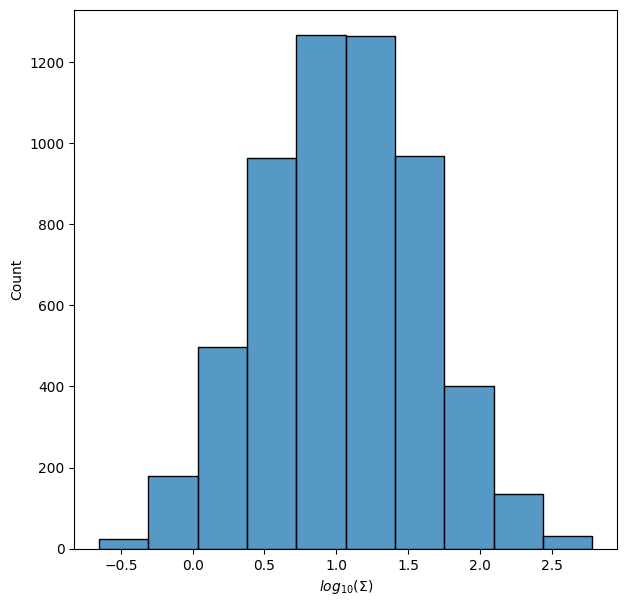

In [77]:
import seaborn as sns
fig,ax = plt.subplots(1,1,figsize=(7,7))
sns.histplot(rho,bins=10,ax=ax)
ax.set_xlabel(r"$log_{10}(\Sigma)$")
plt.savefig("sigma_dist.jpg")

In [63]:
# Calculemos primero el histrograma:
counts,bins = np.histogram(rho,bins=10)
mids = (bins[1:]+bins[:-1])/2
# Build 2d array
rho_type = np.column_stack((rho,tys))





In [64]:
def bin_type_splitter(arr, bins):
    # arr[0] = rho ; arr[1] = type
    s = [
        (len(arr[:,0][np.where((arr[:,0]<b[1])&(arr[:,0]>b[0])&(arr[:,1]==1))]),
         len(arr[:,0][np.where((arr[:,0]<b[1])&(arr[:,0]>b[0])&(arr[:,1]==2))]),
         len(arr[:,0][np.where((arr[:,0]<b[1])&(arr[:,0]>b[0])&(arr[:,1]==3))]),
         len(arr[:,0][np.where((arr[:,0]<b[1])&(arr[:,0]>b[0])&(arr[:,1]==4))]),
        ) for b in zip(bins[:-1],bins[1:])
    ]
    return s

In [65]:
splits = np.array(bin_type_splitter(rho_type,bins))
# np.sum(splits,axis=1) = counts (except for some type 4 galaxies)
s1 = np.array(splits[:,0])/counts
s2 = np.array(splits[:,1])/counts
s3 = np.array(splits[:,2])/counts
s4 = np.array(splits[:,3])/counts


In [86]:
print(s3[0]*100,s3[-1]*100)

56.52173913043478 12.5


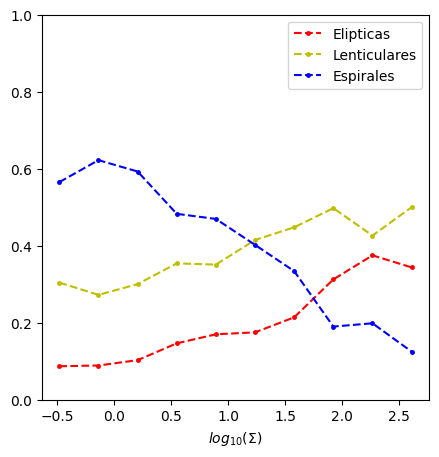

In [82]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(mids,s1,"r--o",markersize=2.5, label="Elipticas")
ax.plot(mids,s2,"y--o",markersize=2.5, label="Lenticulares")
ax.plot(mids,s3,"b--o",markersize=2.5, label="Espirales")
# ax.plot(mids,s4,"c--o",markersize=2.5, label="s4")
ax.set_ylim(0,1)
ax.set_xlabel(r"$log_{10}(\Sigma)$")
plt.legend()
plt.savefig("dens_morf_dist.jpg")
